In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential  
from glob import glob
from keras.applications import VGG16        #used for classification
from keras.applications.inception_v3 import InceptionV3, preprocess_input  
from keras.layers import Dense, Flatten, BatchNormalization, Dropout    
from keras.preprocessing.image import ImageDataGenerator    
from tensorflow.keras.utils import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping   
# both for avoiding overfitting
#modelcheckpoint for saving best model to .h5 file
# early stopping for stopping epochs after patience if the model accuracy is not increasing
from keras.models import load_model

In [2]:
#dataset of fake real recognition
train_path = r"C:\Users\chink\Desktop\6th semester\Deep Learning\Indian Currency Dataset\train"
validation_path = r"C:\Users\chink\Desktop\6th semester\Deep Learning\Indian Currency Dataset\test"

In [3]:
#dataset for classidication
train_dir_class = r"C:\Users\chink\Desktop\6th semester\Deep Learning\Currency dataset\Indian currency dataset v1\training"
test_dir_class = r"C:\Users\chink\Desktop\6th semester\Deep Learning\Currency dataset\Indian currency dataset v1\test"
validation_dir_class = r"C:\Users\chink\Desktop\6th semester\Deep Learning\Currency dataset\Indian currency dataset v1\validation"

In [4]:
# no. of classes in recognition data
className = glob(train_path + "/*")
NumberofClass = len(className)
print("NumberofClass:", NumberofClass)

NumberofClass: 2


In [5]:
# no. of classes in cassification data
className = glob(train_dir_class + "/*")
NumberofClass_class = len(className)
print("NumberofClass:", NumberofClass_class)

NumberofClass: 8


In [6]:
# data augumentation 
train_datagen = ImageDataGenerator(rescale=1/255)    
validation_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

In [7]:
batch_size = 10
# recognition data

train_datagen = ImageDataGenerator(rescale=1/255,
                  shear_range=0.3,
                  horizontal_flip=True,
                  zoom_range=0.3
                  )
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
                train_path,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

val_generator = val_datagen.flow_from_directory(
                validation_path,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

# classification data
train_generator_class = train_datagen.flow_from_directory(
                train_dir_class,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

val_generator_class = val_datagen.flow_from_directory(
                validation_dir_class,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

Found 248 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
Found 3566 images belonging to 8 classes.
Found 345 images belonging to 8 classes.


In [8]:
train_generator.class_indices

{'fake': 0, 'real': 1}

In [9]:
train_generator_class.class_indices

{'10': 0,
 '100': 1,
 '20': 2,
 '200': 3,
 '2000': 4,
 '50': 5,
 '500': 6,
 'Background': 7}

In [10]:
#load inception model for fake real recognition
IncV3 = InceptionV3(include_top = False, weights = "imagenet",input_shape = (224,224,3))

In [11]:
model = Sequential()    #define blank model

model.add(IncV3)    #add inception layer

for layer in model.layers:
    layer.trainable = False    
    
model.add(Flatten())
model.add(Dense(units = 2048, activation = "relu"))

model.add(Dropout(0.3))    #randomly deletes no.of parameters
model.add(Dense(units = NumberofClass, activation = "sigmoid"))    # 2 neurons in o/p layer
# sigmoid for binary class classification

In [12]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])     

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 2048)              104859648 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 126,666,530
Trainable params: 104,863,746
Non-trainable params: 21,802,784
_________________________________________________________________


In [14]:
# .h5 model for saving best model
# monitor = val_accuracy to save model which gives better validation accuracy
mc = ModelCheckpoint(filepath= "./best_model_incv3.h5",monitor = 'val_accuracy',
                     verbose= 1, save_best_only= True)

# patience = 20,  waiting for atleast 20 epochs to stop epochs
es = EarlyStopping(monitor = "accuracy",
                   min_delta= 0.01,
                   patience = 20,
                   verbose= 1)

cb = [mc,es]        

In [15]:
#accuracy = 0.8800
# val accuracy =0.9800
history = model.fit(train_generator,
                    validation_data = val_generator,
                    steps_per_epoch= 10,
                    epochs = 50,
                    callbacks = cb)

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 24.9742 - accuracy: 0.6735
Epoch 1: val_accuracy improved from -inf to 0.83178, saving model to .\best_model_incv3.h5
10/10 [==============================] - 47s 4s/step - loss: 24.9742 - accuracy: 0.6735 - val_loss: 6.6464 - val_accuracy: 0.8318
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 5.2394 - accuracy: 0.8400
Epoch 2: val_accuracy improved from 0.83178 to 0.85981, saving model to .\best_model_incv3.h5
10/10 [==============================] - 32s 3s/step - loss: 5.2394 - accuracy: 0.8400 - val_loss: 7.5097 - val_accuracy: 0.8598
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 4.1419 - accuracy: 0.8980
Epoch 3: val_accuracy did not improve from 0.85981
10/10 [==============================] - 26s 3s/step - loss: 4.1419 - accuracy: 0.8980 - val_loss: 9.0408 - val_accuracy: 0.7944
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 4.7815 - accuracy: 0.8900

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization


In [17]:
# load vgg16 for classification
VGG = VGG16(include_top = False, weights = "imagenet",input_shape = (224,224,3))

In [18]:
# fine tuning 
#releases last 2 lauers for training. this layers gets trained while model is getting fitted
#and weight values are updated for this layers
for layer in VGG.layers[ :-2]:
    layer.trainable = False

In [19]:
model_class = Sequential()

model_class.add(VGG)
model_class.add(Flatten())
model_class.add(Dense(units = 950, activation = "relu"))
model_class.add(Dropout(0.3))
model_class.add(Dense(units = NumberofClass_class, activation = "softmax"))
# softmax for multiclass classification

In [20]:
model_class.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [21]:
model_class.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 950)               23834550  
                                                                 
 dropout_1 (Dropout)         (None, 950)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 7608      
                                                                 
Total params: 38,556,846
Trainable params: 26,201,966
Non-trainable params: 12,354,880
_________________________________________________________________


In [22]:
mc1 = ModelCheckpoint(filepath= "./best_model1_incv3.h5",monitor = 'val_accuracy',
                     verbose= 1, save_best_only= True)

es1 = EarlyStopping(monitor = "val_accuracy",
                   min_delta= 0.01,
                   patience = 50,
                   verbose= 1)

cb1 = [mc1,es1]        

In [23]:
#accuracy = 0.85
#val_accuracy = 0.80
history_class = model_class.fit(train_generator_class,
                    validation_data = val_generator_class,
                    steps_per_epoch= 10,
                    epochs = 150,
                    callbacks = cb1)

Epoch 1/150
10/10 [==============================] - ETA: 0s - loss: 4.3509 - accuracy: 0.2200
Epoch 1: val_accuracy improved from -inf to 0.17101, saving model to .\best_model1_incv3.h5
10/10 [==============================] - 127s 13s/step - loss: 4.3509 - accuracy: 0.2200 - val_loss: 2.2091 - val_accuracy: 0.1710
Epoch 2/150
10/10 [==============================] - ETA: 0s - loss: 2.0808 - accuracy: 0.2200
Epoch 2: val_accuracy did not improve from 0.17101
10/10 [==============================] - 125s 13s/step - loss: 2.0808 - accuracy: 0.2200 - val_loss: 2.2282 - val_accuracy: 0.1710
Epoch 3/150
10/10 [==============================] - ETA: 0s - loss: 1.9345 - accuracy: 0.2800
Epoch 3: val_accuracy improved from 0.17101 to 0.25797, saving model to .\best_model1_incv3.h5
10/10 [==============================] - 126s 14s/step - loss: 1.9345 - accuracy: 0.2800 - val_loss: 1.9298 - val_accuracy: 0.2580
Epoch 4/150
10/10 [==============================] - ETA: 0s - loss: 1.9488 - accura

In [24]:
#load final recognition model for further prediction
model = load_model(r"C:\Users\chink\best_model_incv3.h5")

In [25]:
#load final model for classification
model_class = load_model(r"C:\Users\chink\best_model1_incv3.h5")

In [26]:
h = history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
h1 = history_class.history
h1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

C:\Users\chink\AppData\Local\Temp\ipykernel_11524\386058009.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(h['val_accuracy'], 'go--', c="red")
C:\Users\chink\AppData\Local\Temp\ipykernel_11524\386058009.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(h['val_loss'], 'go--', c="red")


Text(0.5, 1.0, 'loss vs val_loss')

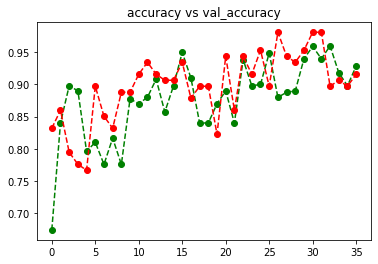

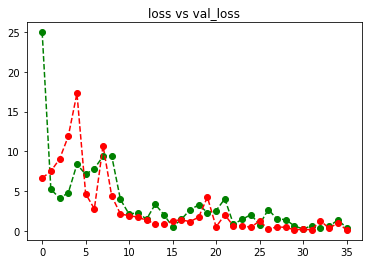

In [28]:
#plot for fake vs real classification
plt.plot(h['accuracy'], 'go--')
plt.plot(h['val_accuracy'], 'go--', c="red")

plt.title("accuracy vs val_accuracy")

plt.figure()

plt.plot(h['loss'], 'go--')
plt.plot(h['val_loss'], 'go--', c="red")

plt.title("loss vs val_loss")

C:\Users\chink\AppData\Local\Temp\ipykernel_11524\1591489472.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(h1['val_accuracy'], 'go--', c="red")
C:\Users\chink\AppData\Local\Temp\ipykernel_11524\1591489472.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(h1['val_loss'], 'go--', c="red")


Text(0.5, 1.0, 'loss vs val_loss')

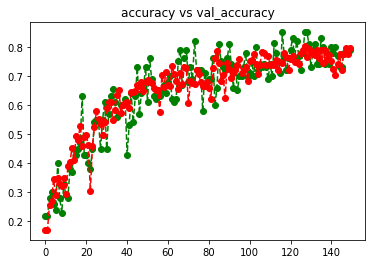

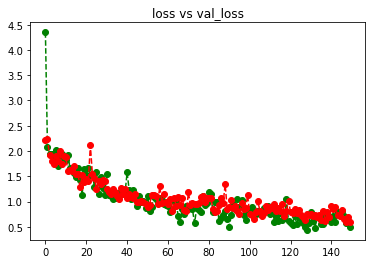

In [29]:
# plot for currency classification

plt.plot(h1['accuracy'], 'go--')
plt.plot(h1['val_accuracy'], 'go--', c="red")

plt.title("accuracy vs val_accuracy")

plt.figure()

plt.plot(h1['loss'], 'go--')
plt.plot(h1['val_loss'], 'go--', c="red")

plt.title("loss vs val_loss")

In [30]:
#test the model

In [1]:
path = r"C:\Users\chink\Desktop\b.jpeg"

In [2]:
#preprocess image
img = load_img(path, target_size=(224,224))
i= img_to_array(img)
i = preprocess_input(i)

input_arr = np.array([i])
input_arr.shape


NameError: name 'load_img' is not defined

1/1 [==============================] - 1s 586ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


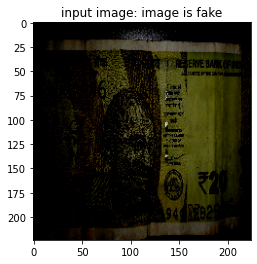

image is fake


In [33]:
pred = np.argmax(model.predict(input_arr))
pred_class = np.argmax(model_class.predict(input_arr))

if pred == 0:
    plt.imshow(input_arr[0])
    plt.title("input image: image is fake")
    plt.axis = False
    plt.show()
    print("image is fake")
    
else:
    if pred_class == 0:
        plt.imshow(input_arr[0])
        plt.title("input image: image is real: 10 rupees")
        plt.axis = False
        plt.show()
        print("image is real: 10 rupees")
        
    elif pred_class == 1:
        plt.imshow(input_arr[0])
        plt.title("input image: image is real: 100 rupeesl")
        plt.axis = False
        plt.show()
        print("image is real: 100 rupees")
        
    elif pred_class == 2:
        plt.imshow(input_arr[0])
        plt.title("input image: image is real: 20 rupees")
        plt.axis = False
        plt.show()
        print("image is real: 20 rupees")
        
    elif pred_class == 3:
        plt.imshow(input_arr[0])
        plt.title("input image: image is real: 200 rupees")
        plt.axis = False
        plt.show()
        print("image is real: 200 rupees")
        
    elif pred_class == 4:
        plt.imshow(input_arr[0])
        plt.title("input image: image is real: 2000 rupees")
        plt.axis = False
        plt.show()
        print("image is real: 2000 rupees")
        
    elif pred_class == 5:
        plt.imshow(input_arr[0])
        plt.title("input image: image is real: 50 rupees")
        plt.axis = False
        plt.show()
        print("image is real: 50 rupees")
        
    elif pred_class == 6:
        plt.imshow(input_arr[0])
        plt.title("input image: image is real: 500 rupees")
        plt.axis = False
        plt.show()
        print("image is real: 500 rupees")
    
    elif pred_class == 7:
        plt.imshow(input_arr[0])
        plt.title("input image: no image")
        plt.axis = False
        plt.show()
        print("no image")